In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report
from imutils import paths
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import zipfile
import random
from shutil import copyfile

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-07-22 14:12:47--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.78.216.154, 2600:1417:8000:9ac::e59, 2600:1417:8000:9ad::e59, ...
Connecting to download.microsoft.com (download.microsoft.com)|23.78.216.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   133MB/s    in 6.2s    

2020-07-22 14:12:53 (126 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [4]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [5]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [6]:
# determine the total number of image paths in training, validation,
# and testing directories
TRAIN_PATH = "/tmp/cats-v-dogs/training/"
VAL_PATH = "/tmp/cats-v-dogs/testing/"
totalTrain = len(list(paths.list_images(TRAIN_PATH)))
totalVal = len(list(paths.list_images(VAL_PATH)))

In [7]:
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=25,
	zoom_range=0.1,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.2,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [8]:
# initialize the initial learning rate, batch size, and number of
# epochs to train for
INIT_LR = 1e-4
BS = 32
NUM_EPOCHS = 20
CLASSES = ["Cat", "Dog"]
MODEL_PATH = "animal_detector.model"

In [9]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
	TRAIN_PATH,
	class_mode="binary",
	target_size=(224, 224),
	batch_size=BS)

# initialize the validation generator
valGen = valAug.flow_from_directory(
	VAL_PATH,
	class_mode="binary",
	target_size=(224, 224),
	batch_size=BS)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [10]:
# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
print("[INFO] preparing model...")
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

# compile the model
opt = Adam(lr=INIT_LR, decay=INIT_LR / NUM_EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the model
print("[INFO] training model...")
H = model.fit(
	trainGen,
	steps_per_epoch=totalTrain // BS,
	validation_data=valGen,
	validation_steps=totalVal // BS,
	epochs=NUM_EPOCHS)

[INFO] preparing model...
94773248/94765736 [==============================] - 1s 0us/step
[INFO] training model...
Epoch 1/20
665/703 [===========================>..] - ETA: 16s - loss: 0.0987 - accuracy: 0.9601

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

703/703 [==============================] - 325s 462ms/step - loss: 0.0976 - accuracy: 0.9605 - val_loss: 0.0621 - val_accuracy: 0.9788
Epoch 2/20
703/703 [==============================] - 321s 457ms/step - loss: 0.0679 - accuracy: 0.9740 - val_loss: 0.0595 - val_accuracy: 0.9764
Epoch 3/20
703/703 [==============================] - 325s 462ms/step - loss: 0.0645 - accuracy: 0.9746 - val_loss: 0.0666 - val_accuracy: 0.9756
Epoch 4/20
703/703 [==============================] - 319s 454ms/step - loss: 0.0594 - accuracy: 0.9771 - val_loss: 0.0595 - val_accuracy: 0.9744
Epoch 5/20
703/703 [==============================] - 330s 469ms/step - loss: 0.0584 - accuracy: 0.9769 - val_loss: 0.0567 - val_accuracy: 0.9776
Epoch 6/20
703/703 [==============================] - 318s 453ms/step - loss: 0.0512 - accuracy: 0.9806 - val_loss: 0.0581 - val_accuracy: 0.9780
Epoch 7/20
703/703 [==============================] - 322s 458ms/step - loss: 0.0478 - accuracy: 0.9816 - val_loss: 0.0579 - val_accura

In [11]:
# serialize the model to disk
print("[INFO] saving model...")
model.save(MODEL_PATH, save_format="h5")

[INFO] saving model...


**Train vs Validation Accuracy and Loss Plot**

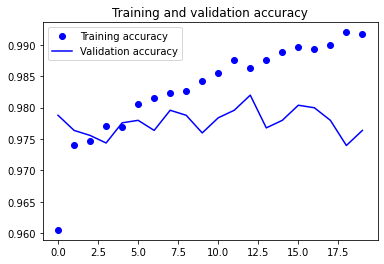

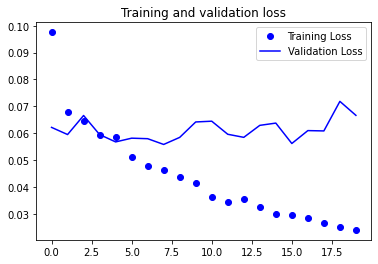

In [12]:
import matplotlib.pyplot as plt
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Using TensorFlow backend.


Saving cat.jpg to cat.jpg
Saving Cat2.jpg to Cat2.jpg
Saving Cat3.jpg to Cat3.jpg
Saving cat4.png to cat4.png
Saving cat5.webp to cat5.webp
Saving dog.jpg to dog.jpg
Saving dog2.jpg to dog2.jpg
Saving Dog3.jpg to Dog3.jpg
Saving dog4.jpg to dog4.jpg
Saving dog5.jpg to dog5.jpg
[0.00018895]
cat.jpg is a cat
[1.747984e-05]
Cat2.jpg is a cat
[2.9094976e-10]
Cat3.jpg is a cat
[9.0118726e-07]
cat4.png is a cat
[0.3022528]
cat5.webp is a cat
[1.]
dog.jpg is a dog
[1.]
dog2.jpg is a dog
[0.15009423]
Dog3.jpg is a cat
[1.]
dog4.jpg is a dog
[0.99999964]
dog5.jpg is a dog
